In [17]:
import pandas as pd
import torch


In [18]:
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('google/multiberts-seed_0-step_2000k')
model = BertForMaskedLM.from_pretrained('google/multiberts-seed_0-step_2000k')

Some weights of the model checkpoint at google/multiberts-seed_0-step_2000k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
list_of_checkpoints = [f'google/multiberts-seed_0-step_{i}k' for i in range(0, 200, 20)] + [f'google/multiberts-seed_0-step_{i}k' for i in range(200, 2001, 100)]

In [20]:
# load the data
df = pd.read_csv('data_processed/niki.csv')

In [21]:
df

,prompt,label,distractor,length,plural_match
0,The tourist hired the guides that the locals a...,guides,tourist,short,mismatch
1,The tourists hired the guides that the locals ...,guides,tourists,short,match
2,The tourist hired the guides that two days ago...,guides,tourist,long,mismatch
3,The tourists hired the guides who two days ago...,guides,tourists,long,match
4,The coach removed the gymnasts that the fans d...,gymnasts,coach,short,mismatch
...,...,...,...,...,...
107,The editors censored the journalists that last...,journalists,editors,long,match
108,The donor bored the researchers that interns d...,researchers,donor,short,mismatch
109,The donors bored the researchers that interns ...,researchers,donors,short,match
110,The donor bored the researchers that last year...,researchers,donor,long,mismatch


In [22]:
text = "The tourist hired the guides that the locals angered due to a misunderstanding. Therefore, the locals angered the [MASK]"
encoded_input = tokenizer(text, return_tensors='pt')
mask_token_index = torch.where(encoded_input['input_ids'] == tokenizer.mask_token_id)[1].item()

with torch.no_grad():
    output = model(**encoded_input)

predictions = output.logits
masked_token_predictions = predictions[0, mask_token_index]
predicted_token_index = torch.argmax(masked_token_predictions).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_token_index])[0]

predicted_token

'tourist'

In [23]:
torch.softmax(masked_token_predictions, dim=0)

tensor([1.8282e-09, 3.0457e-10, 6.1019e-10,  ..., 4.7334e-09, 9.1330e-10,
        1.0664e-09])

In [24]:
first_index = tokenizer.encode("guides", add_special_tokens=False)

In [25]:
second_index = tokenizer.encode("tourist", add_special_tokens=False)

In [26]:
torch.softmax(masked_token_predictions, dim=0)[first_index]

tensor([0.0010])

In [27]:
torch.softmax(masked_token_predictions, dim=0)[second_index]

tensor([0.7780])

In [28]:
# Function to predict the masked token in a given text
def predict_masked_token(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    mask_token_index = torch.where(encoded_input['input_ids'] == tokenizer.mask_token_id)[1].item()

    with torch.no_grad():
        output = model(**encoded_input)

    predictions = output.logits
    masked_token_predictions = predictions[0, mask_token_index]
    predicted_token_index = torch.argmax(masked_token_predictions).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_token_index])[0]

    return predicted_token

In [29]:
# Apply the prediction function to the "prompt" column
df['predicted_token'] = df['prompt'].apply(predict_masked_token)

# Calculate accuracy
accuracy = (df['predicted_token'] == df['label']).mean()

# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 0.19642857142857142


In [30]:
df

,prompt,label,distractor,length,plural_match,predicted_token
0,The tourist hired the guides that the locals a...,guides,tourist,short,mismatch,tourist
1,The tourists hired the guides that the locals ...,guides,tourists,short,match,tourists
2,The tourist hired the guides that two days ago...,guides,tourist,long,mismatch,tourist
3,The tourists hired the guides who two days ago...,guides,tourists,long,match,tourists
4,The coach removed the gymnasts that the fans d...,gymnasts,coach,short,mismatch,coach
...,...,...,...,...,...,...
107,The editors censored the journalists that last...,journalists,editors,long,match,editors
108,The donor bored the researchers that interns d...,researchers,donor,short,mismatch,grant
109,The donors bored the researchers that interns ...,researchers,donors,short,match,researchers
110,The donor bored the researchers that last year...,researchers,donor,long,mismatch,whole


In [31]:
df['correct'] = df['predicted_token'] == df['label']

In [9]:
df.groupby(['plural_match', 'length'])["correct"].mean()

plural_match  length
match         long      0.142857
              short     0.321429
mismatch      long      0.107143
              short     0.214286
Name: correct, dtype: float64

KeyError: 'Column not found: correct'

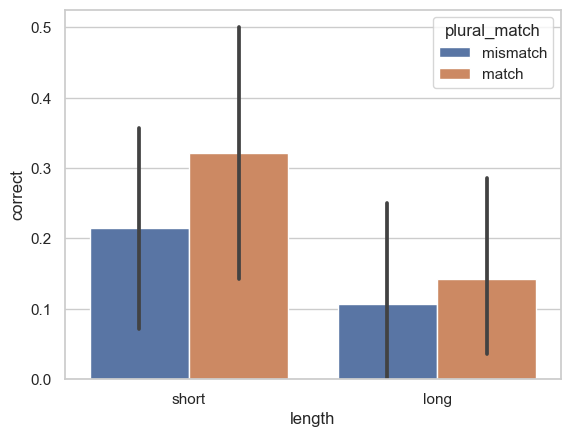

In [10]:
# plot the accuracy by length
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="length", y="correct", hue="plural_match", data=df)
plt.show()
